<a href="https://colab.research.google.com/github/muratkoc503/deneme/blob/master/SegFormer_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUSTOM DATASET TRAIN FOR SEMANTIC SEGMENTATION WITH SEGNET

### pytorch re-install for SegNet

SegNet için pytorch'un farklı sürümü kullanılıyor. Bu yüzden eğitim işlemi bilgisayarın kendi işlemcisi kullanılarak yapılıyorsa(Colab değil anlamında), conda ile yeni environment kur ve orada yap.

In [1]:
!pip install pytorch-lightning transformers datasets roboflow==0.2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Roboflow connection and Dataset Download with Roboflow

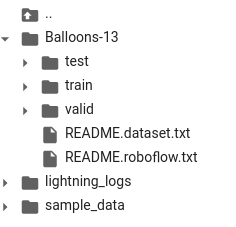

Burada Roboflow'a bağlanarak dataset indiriyor. Drive' kendimizde yükleyip dataset çekebiliriz. Bazı datasetlerin boyutu çok fazla olabiliyor. En mantıklısı, bir daha kullanılmayacaksa kendi linkinden indirmek, kullanılacaksa Google Drive(max: 15Gb)

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="JCY9UG4yzFxIWXu1FOCH")
project = rf.workspace("plantsegment").project("semseg-zz7by")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to semseg-1 in png-mask-semantic:: 100%|██████████| 902/902 [00:00<00:00, 1017.83it/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset Load to Segnet

train_dataset = SemanticSegmentationDataset("./Balloons-13/train/", feature_extractor)

Örnekte Balloons-13 dosya adıdıdr. Değiştirilmesi gerekir.


In [4]:
from IPython.display import Image
from torch.utils.data import Dataset,DataLoader

class SemanticSegmentationDataset(Dataset):

    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}
        
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_()

        return encoded_inputs

In [33]:
import os
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset("./semseg-1/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset("./semseg-1/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset("./semseg-1/test/", feature_extractor)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, prefetch_factor=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3, prefetch_factor=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=3, prefetch_factor=8)

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


### İşlemler

Dokunma

In [6]:
import pytorch_lightning as pl
from PIL import Image
from transformers import SegformerForSemanticSegmentation
from datasets import load_metric

import torch
from torch import nn

import numpy as np

class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})
    
    def validation_epoch_end(self, outputs):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
        
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [36]:
segformer_finetuner = SegformerFinetuner(
    test_dataset.id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TRAIN

Eğitim İşlemi


In [37]:
from keras.preprocessing import image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=3, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    gpus=1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    val_check_interval=len(train_dataloader),
)

#trainer.fit(segformer_finetuner)

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
%pwd

'/content'

In [48]:
class LitModel(SegformerFinetuner):
    def __init__(self, *args, **kwargs):
        super().__init__(    train_dataset.id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,)

x = segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)
model_test = LitModel.load_from_checkpoint('./sample_data/epoch=44-step=1935.ckpt')
res = trainer.test(model_test)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

Testing: 0it [00:00, ?it/s]

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.09652318805456161
   test_mean_accuracy       0.9466056501279536
      test_mean_iou         0.8954410684853993
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### SAMPLE VISUALISATION

In [1]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )

    predicted = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

from matplotlib import pyplot as plt
f, axarr = plt.subplots(predicted.shape[0],2)
for i in range(predicted.shape[0]):
    axarr[i,0].imshow(prediction_to_vis(predicted[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

NameError: ignored

In [ ]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)
    
loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate(
    logits, 
    size=masks.shape[-2:], 
    mode="bilinear", 
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)